# Visualizing a Nanoflare-Heated Active Region
Here we'll import our active region (AR) created with the `synthesizAR` and simulated with EBTEL and visualize the AR at a few different stages. We'll also visualize the $\mathrm{DEM}$, for both all pixels and pixel-averaged, using the [regularized inversion code](https://github.com/ianan/demreg) of [Hannah et al. (2012)](http://adsabs.harvard.edu/abs/2012A%26A...539A.146H).

In [133]:
import os 
import sys
import logging

import numpy as np
from scipy.io import readsav
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.ticker import MaxNLocator,LogFormatter
import seaborn as sns
import astropy.units as u
import sunpy.map
from IPython.display import HTML

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA

sns.set_context(context='notebook',font_scale=1.5)
%matplotlib inline

First, we'll import an existing `Skeleton` object. This holds all of the information about physical field, including the individual loops and their associated thermodynamic quantities.

In [2]:
ar_root = '/data/datadrive2/ar_viz/nessf_example/'
field = synthesizAR.Skeleton.restore(os.path.join(ar_root,'checkpoint'))

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-01-18 09:44:07,391 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-01-18 09:44:07,392 Parameters: domain_dimensions         = [96 96 46]
yt : [INFO     ] 2017-01-18 09:44:07,393 Parameters: domain_left_edge          = [ -9.60112377e+09   3.00297576e+10   4.25949509e+08]
yt : [INFO     ] 2017-01-18 09:44:07,394 Parameters: domain_right_edge         = [  6.06890905e+09   3.95486152e+10   1.02227882e+10]
yt : [INFO     ] 2017-01-18 09:44:07,395 Parameters: cosmological_simulation   = 0.0


## Magnetic Field
The first step is to extrapolate a magnetic field from an HMI observation. Here, we've used NOAA 11640. We use the [`solarbextrapolation`](https://github.com/sunpy/solarbextrapolation) PFSS Python package associated with the SunPy and trace out a total of 500 field lines using the [`yt`](http://yt-project.org/).

Below, we've plotted the extrapolated field lines on top of the HMI magnetogram.

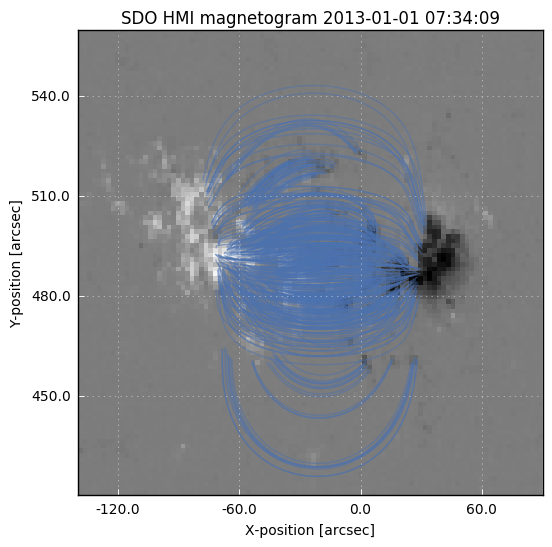

In [6]:
field.peek(figsize=(8,6),alpha=0.5)

## Hydrodynamics
We've modeled the evolution of the loops using the EBTEL model with the [`ebtel++`](http://rice-solar-physics.github.io/ebtelPlusPlus/) code. The evolution of each loop is computed for a total of 5000 s and is heated by a single triangular nanoflare lasting 200 s. The starting times of the events on each loop are randomly distributed between 0 seconds and 4800 seconds. The total energy of each event is determined by
$$
E = \frac{(\varepsilon B)^2}{8\pi}
$$
where $\varepsilon=0.1$ is the stress on the field and $B$ is the average field strength for the particular loop. The panels below show the temperature and density profiles, as computed by EBTEL, superimposed on each other.

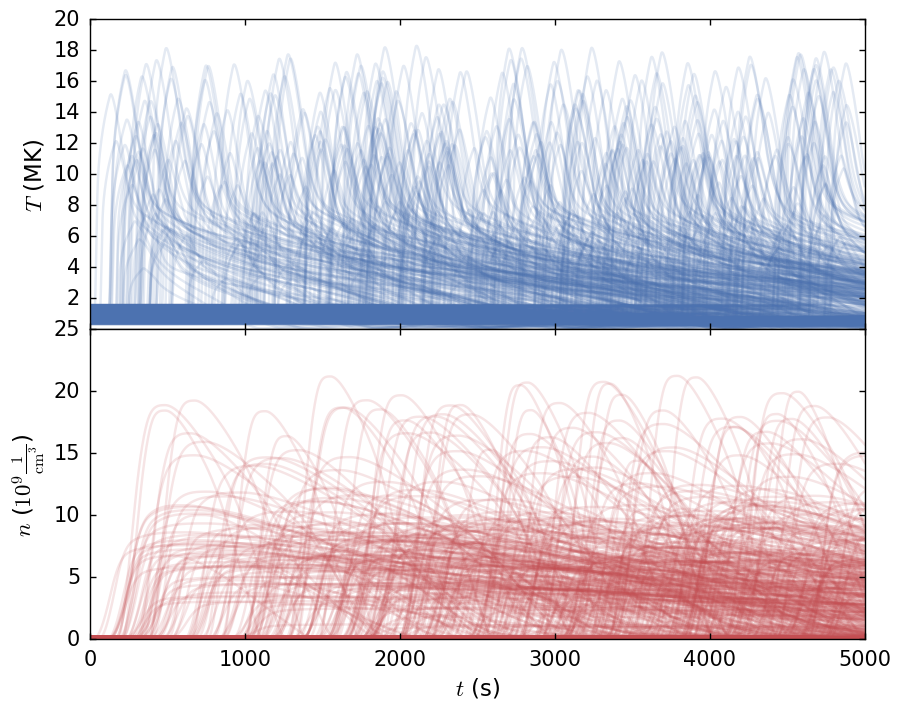

In [10]:
fig,axes = plt.subplots(2,1,figsize=(10,8),sharex=True)
plt.subplots_adjust(hspace=0.0)
for loop in field.loops:
    axes[0].plot(loop.time,loop.temperature[:,0].to(u.MK),color=sns.color_palette('deep')[0],alpha=0.15)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color=sns.color_palette('deep')[2],alpha=0.15)
axes[0].yaxis.set_major_locator(MaxNLocator(prune='lower'))
axes[1].set_xlabel(r'$t$ ({})'.format(loop.time.unit))
axes[0].set_ylabel(r'$T$ ({})'.format(loop.temperature.to(u.MK).unit))
axes[1].set_ylabel(r'$n$ ($10^9${0:latex})'.format(loop.density.unit))

## SDO/AIA Data Products
Using `synthesizAR`,  we've forward modeled the response of each EUV AIA channel (except 304 Å) just using the temperature response functions as computed in SSW. Thus, we do not include effects due to non-equilibrium ionization. `synthesizAR` is also capable of modeling the emission of individual spectral lines and then combining them to compute the intensity of a given channel (spectrometer or imager), though this approach takes a bit longer.

`synthesizAR` treats instruments as objects. We'll declare the AIA object here for convenience.

In [12]:
aia = InstrumentSDOAIA([0,5000]*u.s,
                       response_function_file='/home/wtb2/Documents/research_notebook/FieldLineViz/aia_tresponse_raw.dat')

We produce a `.fits` file for each channel and for each timestep. We can then easily manipulate these using the [SunPy Map object](http://docs.sunpy.org/en/latest/guide/data_types/maps.html) (or alternatively the AIA routines in SSW). We can plot the frames for all channels for a particular time during the simulation,

In [84]:
def plot_aia_frame(time,fig):
    fits_file_template = os.path.join(ar_root,'SDO_AIA/{channel}/map_t{time:06d}.fits')
    j = np.where(aia.observing_time==time)[0][0]
    for i,channel in enumerate(aia.channels):
        _tmp_map = sunpy.map.Map(fits_file_template.format(channel=channel['name'],time=j))
        ax = fig.add_subplot(2,3,i+1,projection=_tmp_map)
        _tmp_map.plot(axes=ax,
                      norm=matplotlib.colors.SymLogNorm(1e-5,vmin=1,vmax=2000),
                      annotate=False)
        #_tmp_map.draw_rectangle((-310, 405)*u.arcsec, 80*u.arcsec, 1*u.arcsec,lw=1,color='red')
        ax.set_title(r'${0}$ $\mathrm{{\mathring{{A}}}}$'.format(channel['name']),fontsize=14)
        if i>2:
            ax.set_xlabel(r'$x$ ({})'.format(_tmp_map.xrange.unit))
        else:
            ax.coords[0].set_ticklabel_visible(False)
        if i%3==0:
            ax.set_ylabel(r'$y$ ({})'.format(_tmp_map.yrange.unit))
        else:
            ax.coords[1].set_ticklabel_visible(False)
    #plt.subplots_adjust(hspace=0.3)
    fig.suptitle(r'$t={0}$ {1}'.format(time.value,time.unit),fontsize=16)
    plt.subplots_adjust(top=0.88,wspace=0.02,hspace=0.2)
    #plt.tight_layout()

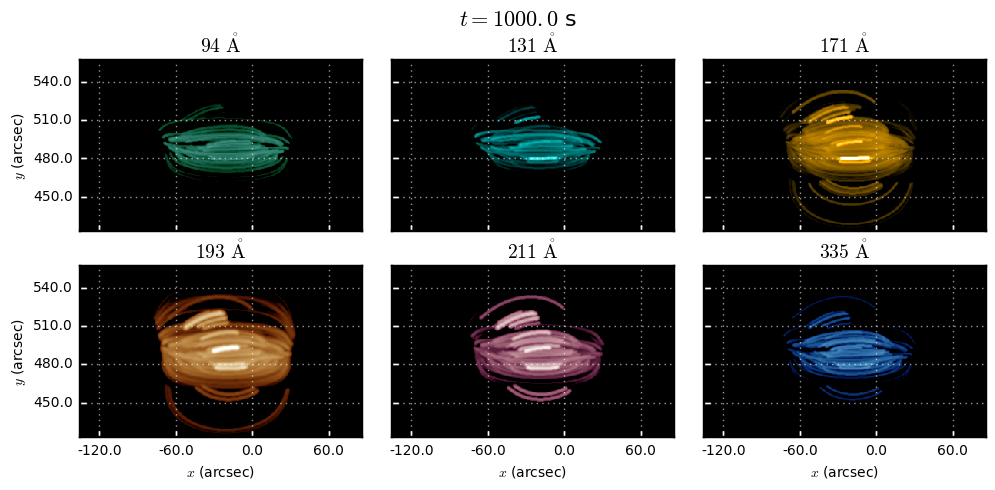

In [85]:
fig = plt.figure(figsize=(12,5))
plot_aia_frame(aia.observing_time[100],fig)

We can also generate a movie to show what the evolution of the AR would like in each channel.

In [86]:
pdf_file_template = os.path.join(ar_root,'figs','SDO_AIA','all_channels_t{time:06d}.pdf')
fig = plt.figure(figsize=(12,5))
for j,time in enumerate(aia.observing_time):
    plot_aia_frame(time,fig)
    plt.savefig(pdf_file_template.format(time=j))
    fig.clf()

In [88]:
%%bash
convert -delay 2 -loop 0 /data/datadrive2/ar_viz/nessf_example/figs/SDO_AIA/*.pdf aia_random_nanoflares.gif

In [91]:
HTML('<img src="aia_random_nanoflares.gif"/>')

## Differential Emission Measure ($\mathrm{DEM}(T)$)
We'll now show the DEM as computed by the `demreg` code of Hannah and Kontar (2012). We show two approaches here: calculating the DEM for the intensity computed by averaging over a group of pixels and computing the DEM in each pixel of the active region. In both cases, we've averaged the intensity over the entire 5000 s of the simulation period.

We don't show how the DEM code is actually run here because it is done in IDL. Need a better way to stitch these two parts of the pipeline together.

### Pixel-averaged

Read in the DEM maps from the IDL save file and plot the distribution. Include a map to show the cutout where the pixel-averaging was done.

In [94]:
dem_1d_info = readsav('/home/wtb2/Documents/NESSF_2017/data/dem_1d_avg.sav')
temperature = 10.**dem_1d_info['logtemps']
temperature_bin_centers = 10.**dem_1d_info['mlogt']
dem = dem_1d_info['dem']
dem_errors = dem_1d_info['edem']

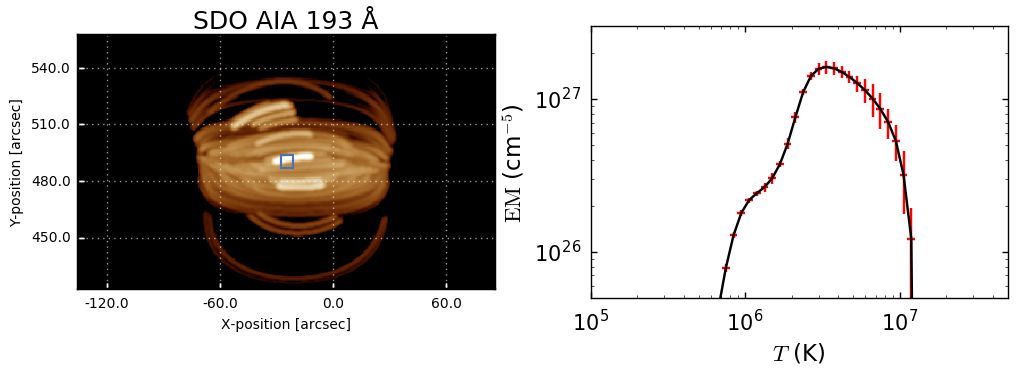

In [127]:
fig = plt.figure(figsize=(12,3.5))
tmp_map = sunpy.map.Map(os.path.join(ar_root,'SDO_AIA/193/map_t000100.fits'))
ax0 = fig.add_subplot(1,2,1,projection=tmp_map)
tmp_map.plot(axes=ax0,norm=matplotlib.colors.SymLogNorm(1e-5,vmin=1,vmax=2000),annotate=True)
xc_pix,yc_pix = tmp_map.data_to_pixel(tmp_map.center[0],tmp_map.center[1])
corner = tmp_map.pixel_to_data(xc_pix-5*u.pixel,yc_pix-5*u.pixel)
tmp_map.draw_rectangle((corner[0].value,corner[1].value)*u.arcsec,
                       11*u.pixel*tmp_map.scale.x,11*u.pixel*tmp_map.scale.y,
                      color=sns.color_palette('deep')[0],lw=1.5)
ax0.set_title('SDO AIA 193 Å')
ax1 = fig.add_subplot(1,2,2)
ax1.errorbar(temperature_bin_centers,dem*np.diff(temperature),yerr=dem_errors*np.diff(temperature),
             xerr=np.diff(temperature)/2.,ecolor='r',color='k')
ax1.set_xlabel(r'$T$ (K)')
ax1.set_ylabel(r'$\mathrm{EM}$ (cm$^{-5}$)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([1e5,5e7])
ax1.set_ylim([5e25,3e27])
plt.subplots_adjust(wspace=0.23)

### 2D Maps

Read in the files and rebuild all of the DEM maps as SunPy Map objects.

In [129]:
dem_info = readsav('/home/wtb2/Documents/NESSF_2017/data/dem_map_avg.sav')
map_file_format = dem_info['map_file_format'].decode('utf8')
_dem_maps = [m['data'] for m in dem_info['dem_maps']]
temperature = 10**dem_info['logtemps']

In [130]:
gen_meta = sunpy.map.Map('/home/wtb2/Documents/NESSF_2017/data/avg_counts_channel94_SDO_AIA.fits').meta
for k in ['detector','waveunit','instrume','wavelnth']:
    if k in gen_meta:
        del gen_meta[k]
gen_meta['bunit'] = (u.cm**-5).to_string()
gen_meta['comment'] = 'output from demreg code'

In [131]:
plot_settings = {
    'norm':matplotlib.colors.SymLogNorm(1,vmin=1e24,vmax=1e28),
    'cmap':matplotlib.cm.get_cmap('viridis')#matplotlib.colors.ListedColormap(sns.color_palette('YlOrRd_r',n_colors=1000))
}
dem_maps = []
for i,dm in enumerate(_dem_maps):
    tmp_meta = gen_meta.copy()
    tmp_meta['temp0'] = temperature[i]
    tmp_meta['temp1'] = temperature[i+1]
    tmp_meta['tempunit'] = u.K.to_string()
    tmp_map = sunpy.map.GenericMap(dm,tmp_meta)
    tmp_map.plot_settings.update(plot_settings)
    dem_maps.append(tmp_map)

Finally, plot each DEM map.

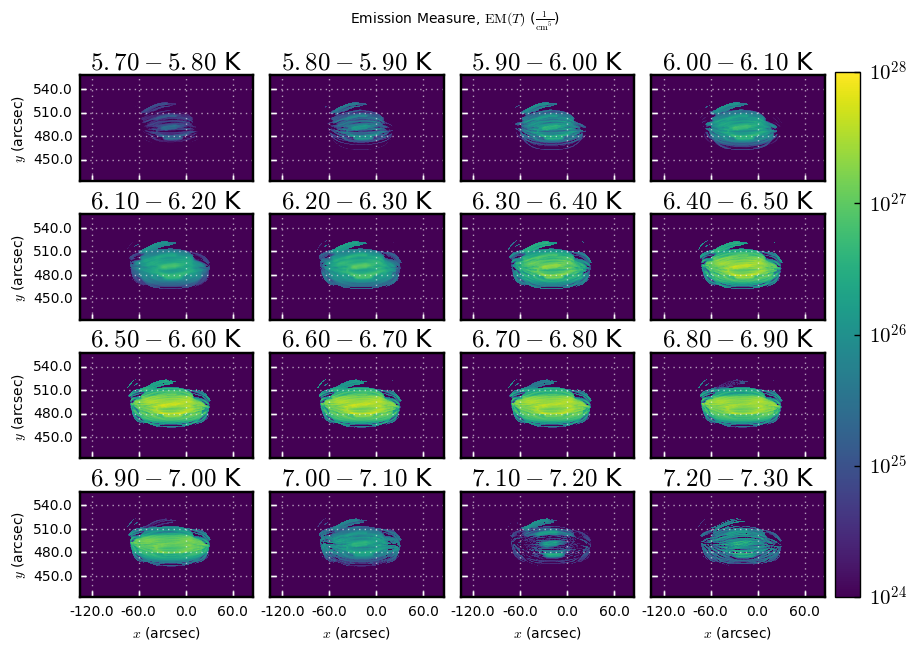

In [134]:
fig = plt.figure(figsize=(10,7))
plt.subplots_adjust(right=0.87)
cax = fig.add_axes([0.88, 0.14, 0.025, 0.75])
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for i,dm in enumerate(dem_maps):
    ax = fig.add_subplot(4,4,i+1,projection=dm)
    im = dm.plot(axes=ax,annotate=False)
    ax.set_title(r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(dm.meta['temp0']),
                                                              t1=np.log10(dm.meta['temp1']),
                                                             uni=dm.meta['tempunit']))
    #ax.text(-120,450,'F',color='w')
    if i<12:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ ({})'.format(u.Unit(dm.meta['cunit1'])))
    if i%4==0:
        ax.set_ylabel(r'$y$ ({})'.format(u.Unit(dm.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)

pow_ticks = [24,25,26,27,28]
cbar = fig.colorbar(im, ticks=10.**np.array(pow_ticks),cax=cax,format=LogFormatter(10,labelOnlyBase=False))
cbar.set_ticklabels([r'$10^{{{}}}$'.format(t) for t in pow_ticks])
fig.suptitle(r'Emission Measure, $\mathrm{{EM}}(T)$ ({uni:latex})'.format(uni=u.Unit(dm.meta['bunit'])))